In [1]:

# from src.transforms import MFCCSumTransform, SpectrogramDBTransform, PseudoCQTTransform
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import librosa
# import nnAudio.Spectrogram
import torch
import yaml
import glob
import os
import sox
import soundfile as sf
import pytorch_lightning as pl
import sklearn.metrics
from itertools import combinations, product
from src.model.resnet import resnet18
from src.dataloader import MultiFXDataset
from torch.utils.data import DataLoader
from tqdm import tqdm


In [3]:
transform = torch.nn.Sequential(torchaudio.transforms.MelSpectrogram(sample_rate=44100,
                                                    n_fft=2048,
                                                    n_mels=128),
                                torchaudio.transforms.AmplitudeToDB()).cuda()
model = resnet18.load_from_checkpoint("lightning_logs/multiFX_resnet_[1,5]_with_clean/checkpoints/epoch=0-step=2999.ckpt",
# model = resnet18.load_from_checkpoint("lightning_logs/multiFX_resnet_[1,5]_no_clean_fixed/checkpoints/epoch=9-step=49061.ckpt",
                           in_channels=2,
                           num_classes=13,
                           with_clean=False,
                           lr=1e-3,
                           transform=transform)
model.eval()

resnet18(
  (transform): Sequential(
    (0): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
    (1): AmplitudeToDB()
  )
  (conv1): Conv2d(2, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=(1, 2), padding=1, dilation=1, ceil_mode=False)
  (layer_1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(

In [4]:
valid_set = MultiFXDataset("dataset/generated/gen_multiFX_IDMT_[1,5]", 'valid', None)
valid_loader = DataLoader(valid_set, batch_size=64, num_workers=2)
trainer = pl.Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [5]:
model.cuda()
y = torch.randn(1, 13, requires_grad=False).cuda()
y_hat = torch.randn(1, 13, requires_grad=False).cuda()
with torch.no_grad():
    for batch in tqdm(valid_loader):
        x, y_batch = batch
#         x = x[:,1,:].unsqueeze(1)
        y_hat_batch = model(x.cuda())
        y = torch.vstack([y, y_batch.cuda()])
        y_hat = torch.vstack([y_hat, y_hat_batch.cuda()])
        del x, y_batch, y_hat_batch
        torch.cuda.empty_cache()

100%|██████████| 2245/2245 [09:19<00:00,  4.02it/s]


In [8]:
y_hat = (torch.sigmoid(y_hat) > 0.5)

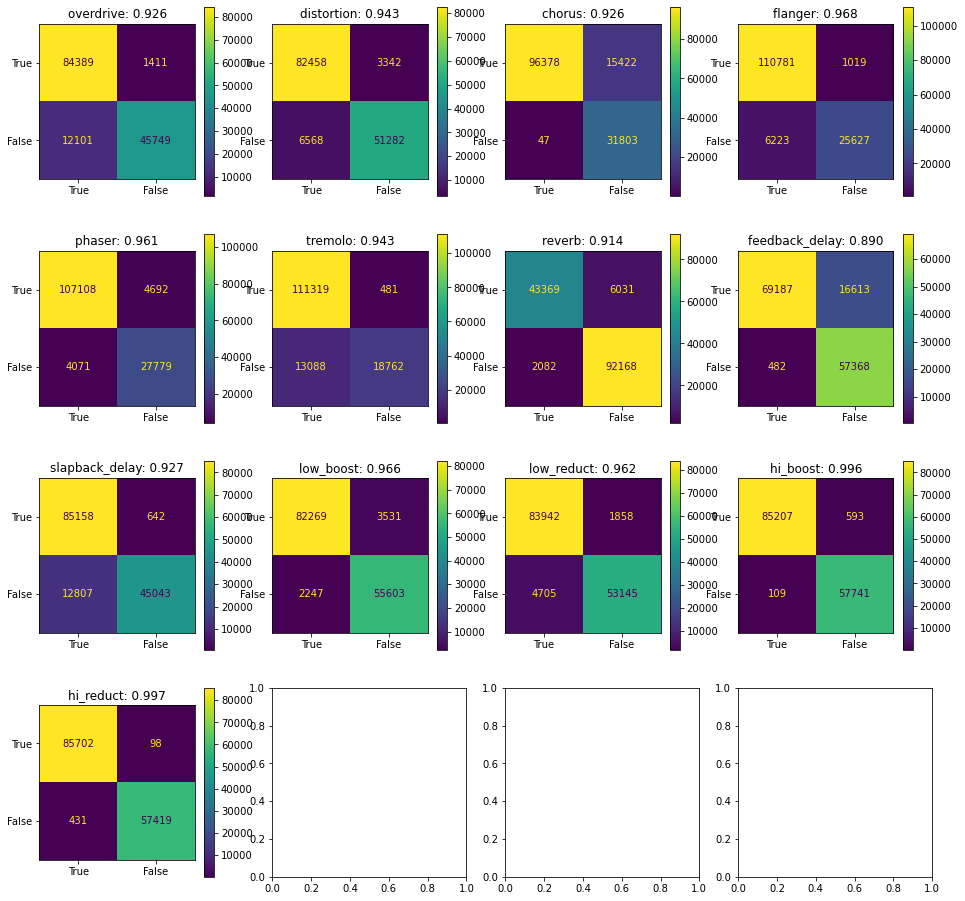

In [12]:
classes = list(valid_set.settings['fx_params'].keys())

fig, ax = plt.subplots(4, 4)
fig.set_size_inches(16, 16)
cms = sklearn.metrics.multilabel_confusion_matrix(y[1:].cpu().to(torch.int), y_hat[1:].cpu().to(torch.int))
for i in range(len(classes)):
    disp = sklearn.metrics.ConfusionMatrixDisplay(cms[i], display_labels=["True", "False"])
    # disp = sklearn.metrics.ConfusionMatrixDisplay(cms[i], colorbar=False)
    axis = ax[i//4][i%4]
    disp.plot(ax=axis)
    TP, FP, FN, TN = cms[i][0][0], cms[i][0][1], cms[i][1][0], cms[i][1][1]
    P = TP / (TP + FP)
    R = TP / (TP + FN)
    axis.set_title(f"{classes[i]}: {2 * (P * R) / (P + R):.3f}")
    axis.set_xlabel("")
    axis.set_ylabel("")

# plt.show()
plt.savefig("figures/multiFX_resnet18_with_clean_IDMT_[1,5].png")